# Lagrange Model for Von_Mises_Stress(pascal)

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# load dataset
# add a new column 'Bird(m/s)'*'Blade(rad/s)' as BirdxBlade
data_raw = pd.read_csv('LagrangeJournalBirdStrikeValueupto50.csv')
data_raw['BirdxBlade'] = data_raw['Bird(m/s)'] * data_raw['Blade(rad/s)'] 
data_raw['Bird^2'] = data_raw['Bird(m/s)'] ** 2
data_raw['Blade^2'] = data_raw['Blade(rad/s)'] ** 2

In [3]:
data_raw.describe()

,test_set,Bird(m/s),Blade(rad/s),Max_TD(mm),Von_Mises_Stress(pascal),Total_Energy,BirdxBlade,Bird^2,Blade^2
count,49.00000,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01,49.000000,49.000000,49.000000
mean,25.00000,182.500000,515.000000,0.670000,1.167274e+09,1.821396e+06,96487.500000,34556.250000,270225.000000
std,14.28869,35.721725,71.443451,0.188392,4.449917e+07,5.044295e+05,31516.098317,13087.211225,73725.175907
min,1.00000,122.500000,395.000000,0.350000,1.059400e+09,1.037200e+06,48387.500000,15006.250000,156025.000000
25%,13.00000,152.500000,455.000000,0.490000,1.151850e+09,1.390000e+06,69387.500000,23256.250000,207025.000000
50%,25.00000,182.500000,515.000000,0.740000,1.172436e+09,1.787100e+06,93987.500000,33306.250000,265225.000000
75%,37.00000,212.500000,575.000000,0.830000,1.195846e+09,2.234322e+06,122187.500000,45156.250000,330625.000000
max,49.00000,242.500000,635.000000,0.950000,1.276456e+09,2.731651e+06,153987.500000,58806.250000,403225.000000


# Plot outputs for Von_Mises_Stress(pascal)

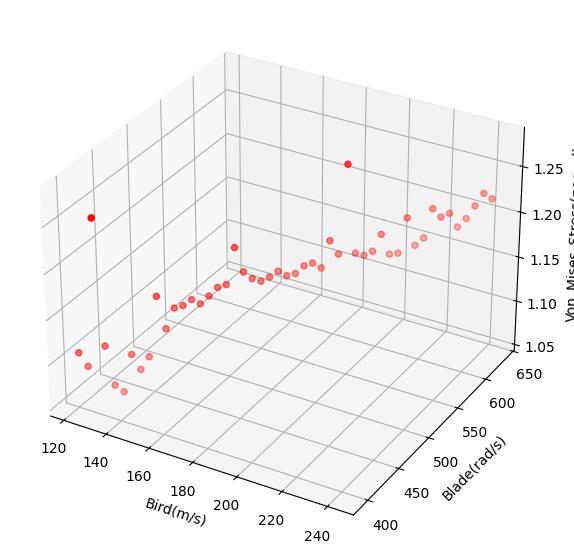

In [4]:
# plot Von_Mises_Stress vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Von_Mises_Stress(pascal)'], c='r', marker='o')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Von_Mises_Stress(pascal)')
plt.show()

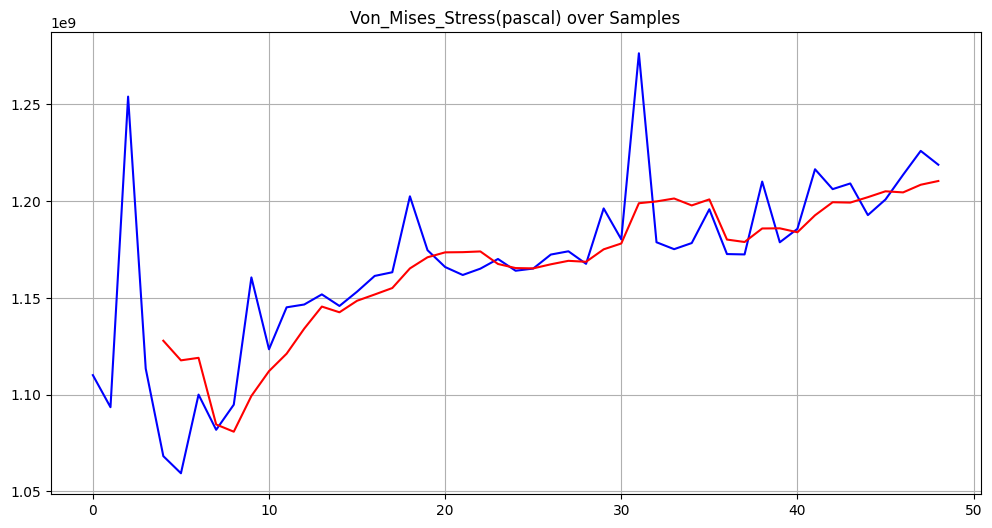

In [5]:
# plot test_set vs Von_Mises_Stress(pascal) from data_raw
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(data_raw['Von_Mises_Stress(pascal)'], label='Actual Von_Mises_Stress(pascal)', color='b')
plt.plot(data_raw['Von_Mises_Stress(pascal)'].rolling(window=5).mean(), label='Rolling Mean (window=5)', color='r')
plt.title('Von_Mises_Stress(pascal) over Samples')

plt.grid(True)
plt.show()

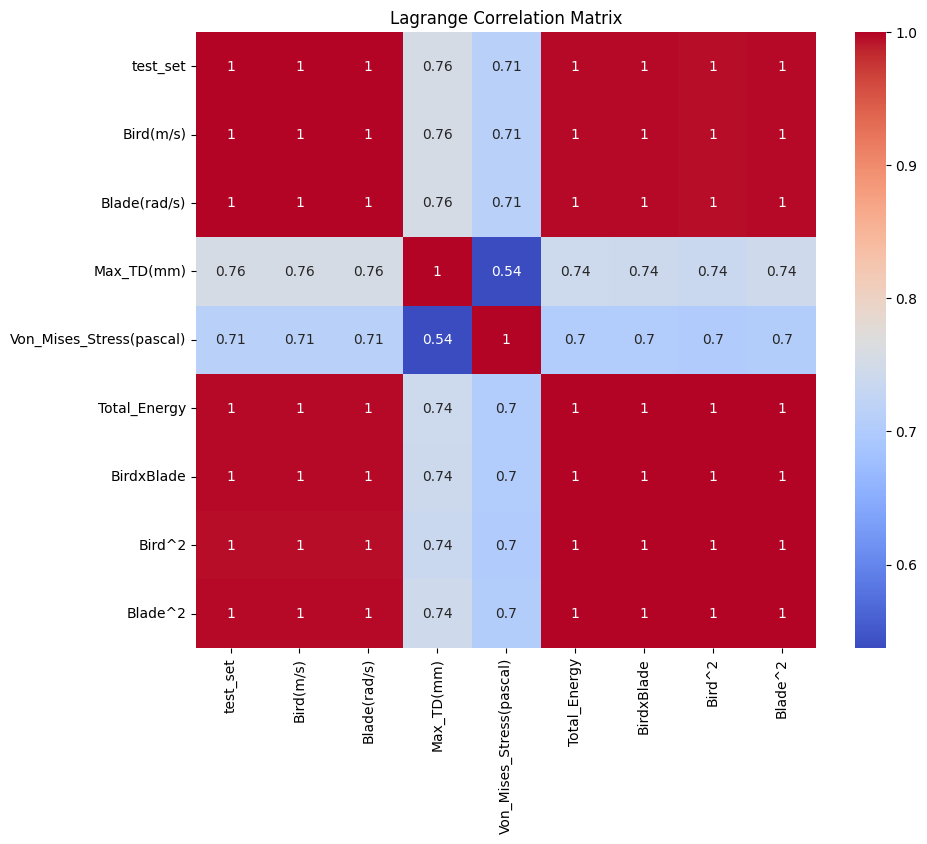

In [6]:
# Plot the correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = data_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Lagrange Correlation Matrix')
plt.show()

# 1. Random Forest Regressor (RF)

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = data_raw[['test_set','Bird(m/s)', 'Blade(rad/s)', 'BirdxBlade', 'Bird^2', 'Blade^2']]
y = data_raw['Von_Mises_Stress(pascal)'] / 1e6  # Convert to megapascals for better scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=15 ,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")

print ("\n k mean cross validation \n")

# Do K mean cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
    )
    
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf = rf_model_kf.predict(X_test_kf)
    
    mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
    r2_kf = r2_score(y_test_kf, y_pred_kf)
    rmse_kf = np.sqrt(mse_kf)
    rmse_list.append(rmse_kf)
average_rmse = np.mean(rmse_list)
print(f"Average RMSE from K-Fold CV: {average_rmse:.4f}")
print(f"RMSEs from each fold: {rmse_list}")
print(f"R²   : {r2_kf:.4f}")
print(f"MSE  : {mse_kf:.4f}")

# At fold 4 :
# likely at very high or very low speeds the model finds harder to predict.

# Feature imporatnace in number format
importances = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)



RMSE : 30.5331
R²   : 0.2528
MSE  : 932.2701

 k mean cross validation 

Average RMSE from K-Fold CV: 31.2880
RMSEs from each fold: [np.float64(30.20117227163254), np.float64(22.805131934968543), np.float64(33.269150149582806), np.float64(52.02873164818516), np.float64(18.135911624685985)]
R²   : 0.7977
MSE  : 328.9113

Feature Importances:
        Feature  Importance
2  Blade(rad/s)    0.191086
1     Bird(m/s)    0.188580
4        Bird^2    0.174447
3    BirdxBlade    0.160449
5       Blade^2    0.144189
0      test_set    0.141249


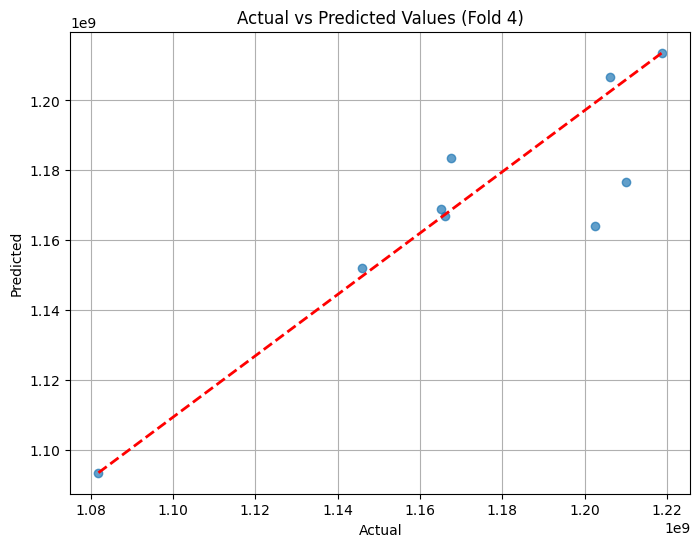

In [12]:
# Residual Analysis
# To solve the "Fold 4" mystery, we need to see where the model fails.
# Action: Plot your Actual vs. Predicted values.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_kf, y_pred_kf, alpha=0.7)
plt.plot([y_test_kf.min(), y_test_kf.max()], [y_pred_kf.min(), y_pred_kf.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Fold 4)')
plt.grid(True)
plt.show()

The "Fold 4" Diagnosis:
- The Major Outlier: Look at the point on the far right (Actual $\approx$ 0.83). The model predicted it at roughly 0.63. This is a massive under-estimation. Because this point is so far from the red line, it is likely single-handedly tanking your MSE/R-squared for this fold.
- Over-estimation at the Top: For actual values between 0.7 and 0.8, almost all your blue dots are above the red line. This means the model is consistently over-predicting in that specific range.
- Low Sample Size: I see only about 8 or 9 data points. In a fold this small, one bad prediction (like that 0.83 value) has a disproportionate impact on the "success" of the fold.

# 2. Gaussian Process Regression (GPR)

In [40]:
# Gaussian Process Regression (GPR) model to predict Max_TD same as random forest model above
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
scaler = StandardScaler()

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr_model.fit(X_train, y_train)
y_pred_gpr = gpr_model.predict(X_test)
mse_gpr = mean_squared_error(y_test, y_pred_gpr)
r2_gpr = r2_score(y_test, y_pred_gpr)
print(f'GPR Model - MSE: {mse_gpr:.4f}')
print(f'GPR Model - RMSE: {np.sqrt(mse_gpr):.4f}')
print(f'GPR R² Score: {r2_gpr:.4f}')
y_train_scaled = scaler.fit_transform(X_train)
y_test_scaled = scaler.transform(X_test)

# k fold cross validation for GPR
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_gpr = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    gpr_model_kf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    
    gpr_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_gpr = gpr_model_kf.predict(X_test_kf)
    
    mse_kf_gpr = mean_squared_error(y_test_kf, y_pred_kf_gpr)
    r2_kf_gpr = r2_score(y_test_kf, y_pred_kf_gpr)
    rmse_kf_gpr = np.sqrt(mse_kf_gpr)
    rmse_list_gpr.append(rmse_kf_gpr)
average_rmse_gpr = np.mean(rmse_list_gpr)
print(f"\n Average RMSE from K-Fold CV (GPR): {average_rmse_gpr:.4f}")
print(f"RMSEs from each fold (GPR): {rmse_list_gpr}")
print(f"R²   : {r2_kf_gpr:.4f}")
print(f"MSE  : {mse_kf_gpr:.4f}")

# feature importance is not directly available for GPR models



GPR Model - MSE: 1416813.8706
GPR Model - RMSE: 1190.2999
GPR R² Score: -1134.5717

 Average RMSE from K-Fold CV (GPR): 1168.1475
RMSEs from each fold (GPR): [np.float64(1190.2999078520702), np.float64(1148.132929266205), np.float64(1160.2842924843683), np.float64(1167.5157694074837), np.float64(1174.5044908298912)]
R²   : -847.3587
MSE  : 1379460.7990


c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found

# 3. Support Vector Regression (SVR) with RBF Kernel

In [43]:
# Prepare features and target
X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Von_Mises_Stress(pascal)'] / 1e6  # Convert to megapascals for better scaling

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
model = SVR(kernel='rbf', C=160, gamma= 1, epsilon=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse_svr = mean_squared_error(y_test, y_pred)
rmse_svr = np.sqrt(mse)
r2_svr = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

# model = SVR(kernel='rbf', C=160, gamma= 0.2, epsilon=0.1)
# Mean Squared Error: 0.0053
# RMSE: 0.0729
# R² Score: 0.7825

# k fold cross validation for SVR
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_svr = []
for train_index, test_index in kf.split(X): 
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize features for each fold
    scaler_kf = StandardScaler()
    X_train_kf_scaled = scaler_kf.fit_transform(X_train_kf)
    X_test_kf_scaled = scaler_kf.transform(X_test_kf)
    
    svr_model_kf = SVR(kernel='rbf', C=160, gamma= 1, epsilon=0.1)
    
    svr_model_kf.fit(X_train_kf_scaled, y_train_kf)
    y_pred_kf_svr = svr_model_kf.predict(X_test_kf_scaled)
    
    mse_kf_svr = mean_squared_error(y_test_kf, y_pred_kf_svr)
    r2_kf_svr = r2_score(y_test_kf, y_pred_kf_svr)
    rmse_kf_svr = np.sqrt(mse_kf_svr)
    rmse_list_svr.append(rmse_kf_svr)
average_rmse_svr = np.mean(rmse_list_svr)
print(f"\nAverage RMSE from K-Fold CV (SVR): {average_rmse_svr:.4f}")
print(f"RMSEs from each fold (SVR): {rmse_list_svr}")
print(f"R²   : {r2_kf_svr:.4f}")
print(f"MSE  : {mse_kf_svr:.4f}")

# fearture importance is not directly available for SVR models

Mean Squared Error: 953.3002
RMSE: 30.8756
R² Score: 0.2359

Average RMSE from K-Fold CV (SVR): 27.5510
RMSEs from each fold (SVR): [np.float64(32.22242133168082), np.float64(13.979922078467178), np.float64(19.888421585624368), np.float64(52.06034305743562), np.float64(19.603716464139723)]
R²   : 0.7637
MSE  : 384.3057


In [15]:
# Example prediction
example_data = np.array([[132, 400]])  # Example: Bird speed = 132 m/s, Blade speed = 400 rad/s
example_data_scaled = scaler.transform(example_data)
predicted_max_td = model.predict(example_data_scaled)
print(f'Predicted Von_Mises_Stress(pascal) for Bird=132 m/s and Blade=400 rad/s: {predicted_max_td[0]:.4f} mm')

Predicted Von_Mises_Stress(pascal) for Bird=132 m/s and Blade=400 rad/s: 1167645860.9410 mm


c:\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 4. Polynomial Regression

In [42]:
# polynomial regression model to predict Max_TD
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
lin_reg.fit(X_train_poly, y_train)
y_pred_poly = lin_reg.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Polynomial Regression Model - MSE: {mse_poly:.4f}')
print(f'Polynomial Regression Model - RMSE: {np.sqrt(mse_poly):.4f}')
print(f'Polynomial Regression R² Score: {r2_poly:.4f}')

# k fold cross validation for polynomial regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_poly = []
for train_index, test_index in kf.split(X_poly):
    X_train_kf, X_test_kf = X_poly[train_index], X_poly[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    lin_reg_kf = LinearRegression()
    
    lin_reg_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_poly = lin_reg_kf.predict(X_test_kf)
    
    mse_kf_poly = mean_squared_error(y_test_kf, y_pred_kf_poly)
    r2_kf_poly = r2_score(y_test_kf, y_pred_kf_poly)
    rmse_kf_poly = np.sqrt(mse_kf_poly)
    rmse_list_poly.append(rmse_kf_poly)
average_rmse_poly = np.mean(rmse_list_poly)
print(f"\nAverage RMSE from K-Fold CV (Polynomial Regression): {average_rmse_poly:.4f}")
print(f"RMSEs from each fold (Polynomial Regression): {rmse_list_poly}")
print(f"R²   : {r2_kf_poly:.4f}")
print(f"MSE  : {mse_kf_poly:.4f}")

# feature importance is not directly available for polynomial regression models

Polynomial Regression Model - MSE: 1108.6787
Polynomial Regression Model - RMSE: 33.2968
Polynomial Regression R² Score: 0.1114

Average RMSE from K-Fold CV (Polynomial Regression): 34.1377
RMSEs from each fold (Polynomial Regression): [np.float64(33.29682697513026), np.float64(22.07105953662877), np.float64(38.25155063433679), np.float64(56.423972080947834), np.float64(20.645321860446195)]
R²   : 0.7379
MSE  : 426.2293


# 5. XGBoost

In [ ]:
# XgBoost model to predict Max_TD
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=21,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Model - MSE: {mse_xgb:.4f}')
print(f'XGBoost Model - RMSE: {np.sqrt(mse_xgb):.4f}')
print(f'XGBoost R² Score: {r2_xgb:.4f}')

# k fold cross validation for XGBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_xgb = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model_kf = xgb.XGBRegressor(
        n_estimators=21,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)
    
    mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
    r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)
    rmse_kf_xgb = np.sqrt(mse_kf_xgb)
    rmse_list_xgb.append(rmse_kf_xgb)
average_rmse_xgb = np.mean(rmse_list_xgb)
print(f"\nAverage RMSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
print(f"RMSEs from each fold (XGBoost): {rmse_list_xgb}")
print(f"R²   : {r2_kf_xgb:.4f}")
print(f"MSE  : {mse_kf_xgb:.4f}")
# Feature importance for XGBoost
importances = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


XGBoost Model - MSE: 1045192303968256.0000
XGBoost Model - RMSE: 32329434.0187
XGBoost R² Score: 0.1623

Average RMSE from K-Fold CV (XGBoost): 36127227.0905
RMSEs from each fold (XGBoost): [np.float64(32379047.62208351), np.float64(50152130.52491549), np.float64(32566333.418047294), np.float64(45956871.7569053), np.float64(19581752.13075847)]
R²   : 0.7642
MSE  : 383445016510464.0000

XGBoost Feature Importances:
        Feature  Importance
0     Bird(m/s)    0.508305
1  Blade(rad/s)    0.491695


In [18]:
def select_best_model(df, sort_by_metrics):
    """
    Ranks models based on a list of metrics (in order of priority) 
    and returns the best model name.

    Args:
        df (pd.DataFrame): The model performance DataFrame.
        sort_by_metrics (list of tuples): A list where each tuple is 
            (metric_name, maximize_boolean). 
            True=Higher is better (e.g., R^2, Accuracy).
            False=Lower is better (e.g., MSE, RMSE).
    
    Returns:
        str: The name of the best performing model.
    """
    sort_columns = []
    ascending_list = []
    
    for metric, maximize in sort_by_metrics:
        sort_columns.append(metric)
        ascending_list.append(not maximize)
    
    ranked_df = df.sort_values(by=sort_columns, ascending=ascending_list)
    best_model = ranked_df.iloc[0]['Model']
    
    return best_model

# Create a DataFrame to summarize model performances
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Gaussian Process', 'SVR', 'Polynomial Regression', 'XGBoost'],
    'RMSE': [np.sqrt(mse), np.sqrt(mse_gpr), np.sqrt(mse_svr), np.sqrt(mse_poly), np.sqrt(mse_xgb)],
    'R2': [r2, r2_gpr, r2_svr, r2_poly, r2_xgb],
    'MSE': [mse, mse_gpr, mse_svr, mse_poly, mse_xgb],
    'k fold R2': [r2_kf, r2_kf_gpr, r2_kf_svr, r2_kf_poly, r2_kf_xgb],
    'k fold RMSE': [average_rmse, average_rmse_gpr, average_rmse_svr, average_rmse_poly, average_rmse_xgb],
    'k fold MSE': [mse_kf, mse_kf_gpr, mse_kf_svr, mse_kf_poly, mse_kf_xgb]
})
print("\nModel Performance Summary:")
print(model_performance)

print ("====================================================================================\n\n")

# 3. STRATEGY DEFINITION: EDIT THESE LISTS TO DEFINE YOUR PRIORITIES
sort_by_metrics = [
    ('k fold R2', True),   # Maximize k fold R2
    ('k fold RMSE', False), # Minimize k fold RMSE
    ('R2', True),          # Maximize R2
    ('RMSE', False)        # Minimize RMSE
]
best_model = select_best_model(model_performance, sort_by_metrics)
print(f"The best performing model is: {best_model}")



Model Performance Summary:
                   Model          RMSE         R2           MSE  k fold R2  \
0          Random Forest  3.068021e+07   0.245571  9.412756e+14   0.791053   
1       Gaussian Process  1.633645e+08 -20.390306  2.668795e+16  -5.049164   
2                    SVR  4.168051e+07  -0.392412  1.737265e+15  -0.001063   
3  Polynomial Regression  3.034161e+07   0.262131  9.206136e+14   0.703769   
4                XGBoost  3.232943e+07   0.162282  1.045192e+15   0.764184   

    k fold RMSE    k fold MSE  
0  3.132016e+07  3.397559e+14  
1  3.576488e+08  9.836152e+15  
2  4.435329e+07  1.627764e+15  
3  3.166827e+07  4.816812e+14  
4  3.612723e+07  3.834450e+14  


The best performing model is: Random Forest


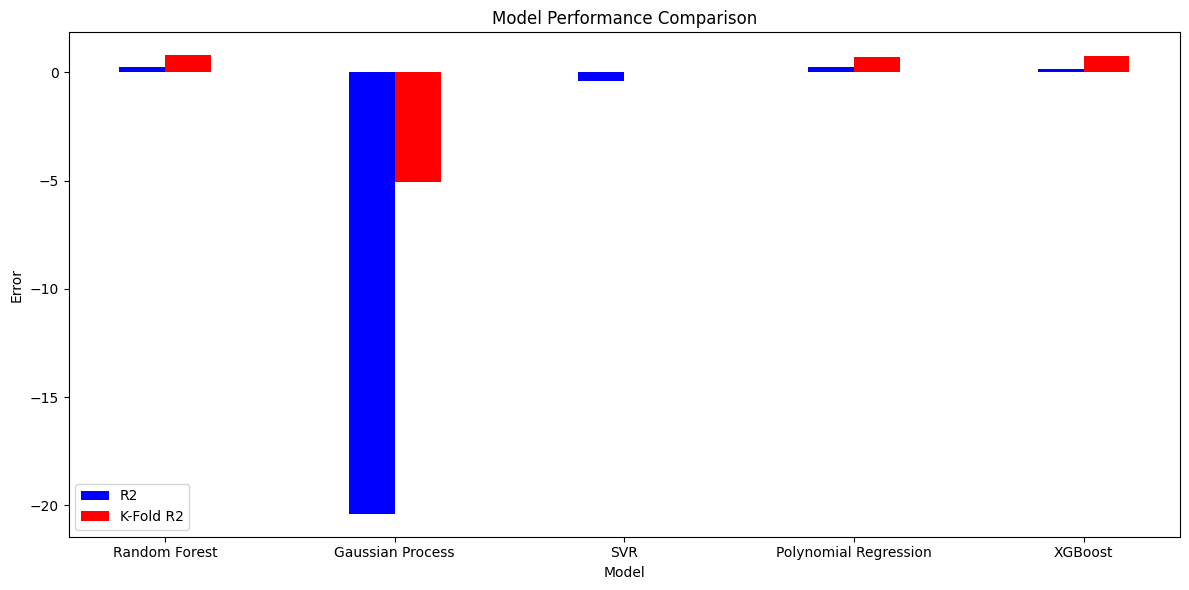

In [22]:
# create a bar plot for model performance comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(model_performance['Model']))
plt.bar(x, model_performance['R2'], width=bar_width, label='R2', color='b', align='center')
plt.bar(x + bar_width, model_performance['k fold R2'], width=bar_width, label='K-Fold R2', color='r', align='center')
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Model Performance Comparison')
plt.xticks(x + bar_width / 2, model_performance['Model'])
plt.legend()
plt.tight_layout()
plt.show()